## Домашнее задание: "Обучение модели metric learning и анализ работы нейронной сети"

ФИО: Исмаилов Адиль

## Описание задания:
В этой домашней работе вам предстоит решить задачу ассоциации изображений методами metric learning. Необходимо обучить нейронную сеть для поиска похожих автомобилей из датасета cars196. Учтите, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта (не используем метод прямой классификации). Пример формирования предсказаний можно найти в ноутбуке: [metric_learning.ipynb](metric_learning.ipynb) блок Faiss.

В процессе решения нужно решить пункты:

1. Реализовать метрики: Precision@k, Recall@k, mAP **1 балл**.
2. Добавить train аугментации **1 балл**.  
3. Обучить модель **2 балл**.  
    1. При обучении использовать backbone отличный от того, что использовался на семинаре (не ResNet50)
    2. Добавить triplet-loss (помните о грамотном формировании триплетов)
    3. Рассчитать метрики из п.1

4. Показать с помощью GradCAM, где ошибается модель **1 балл**.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, BatchSampler
import torchvision
import numpy as np
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io
from sklearn.model_selection import train_test_split
from pytorch_metric_learning.samplers import MPerClassSampler
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_metric_learning import losses, miners
import timm
import faiss
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
device = 'cuda'

In [3]:
def show_image(image, figsize=(10, 10)):
    img_np = inv_normalize(image).permute(1, 2, 0).numpy()
    plt.figure(figsize=figsize)
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

def inv_normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    inv_tensor = tensor * std + mean
    inv_tensor = torch.clamp(inv_tensor, 0, 1)
    return inv_tensor

Загрузим датасет cars196

In [4]:
!gdown 1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7
!gdown 1l9EnYMC-xGX706SY1kN8RceMmFViASfx


Downloading...
From: https://drive.google.com/uc?id=1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7
To: /content/devkit.zip
100% 332k/332k [00:00<00:00, 4.51MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx
From (redirected): https://drive.google.com/uc?id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx&confirm=t&uuid=cd2e92d0-71c2-4143-9a42-ee36106d9118
To: /content/archive.zip
100% 1.96G/1.96G [00:30<00:00, 63.6MB/s]


#### Сформируем train, val и test датасеты

Т.к. у cars_test нет меток, то precison@k, recall@k и mAP посчитать не получится, поэтому будем разделять cars_train на train, val и test.

In [6]:
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}

cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [7]:
TRAIN_PATH = './cars_train/cars_train'

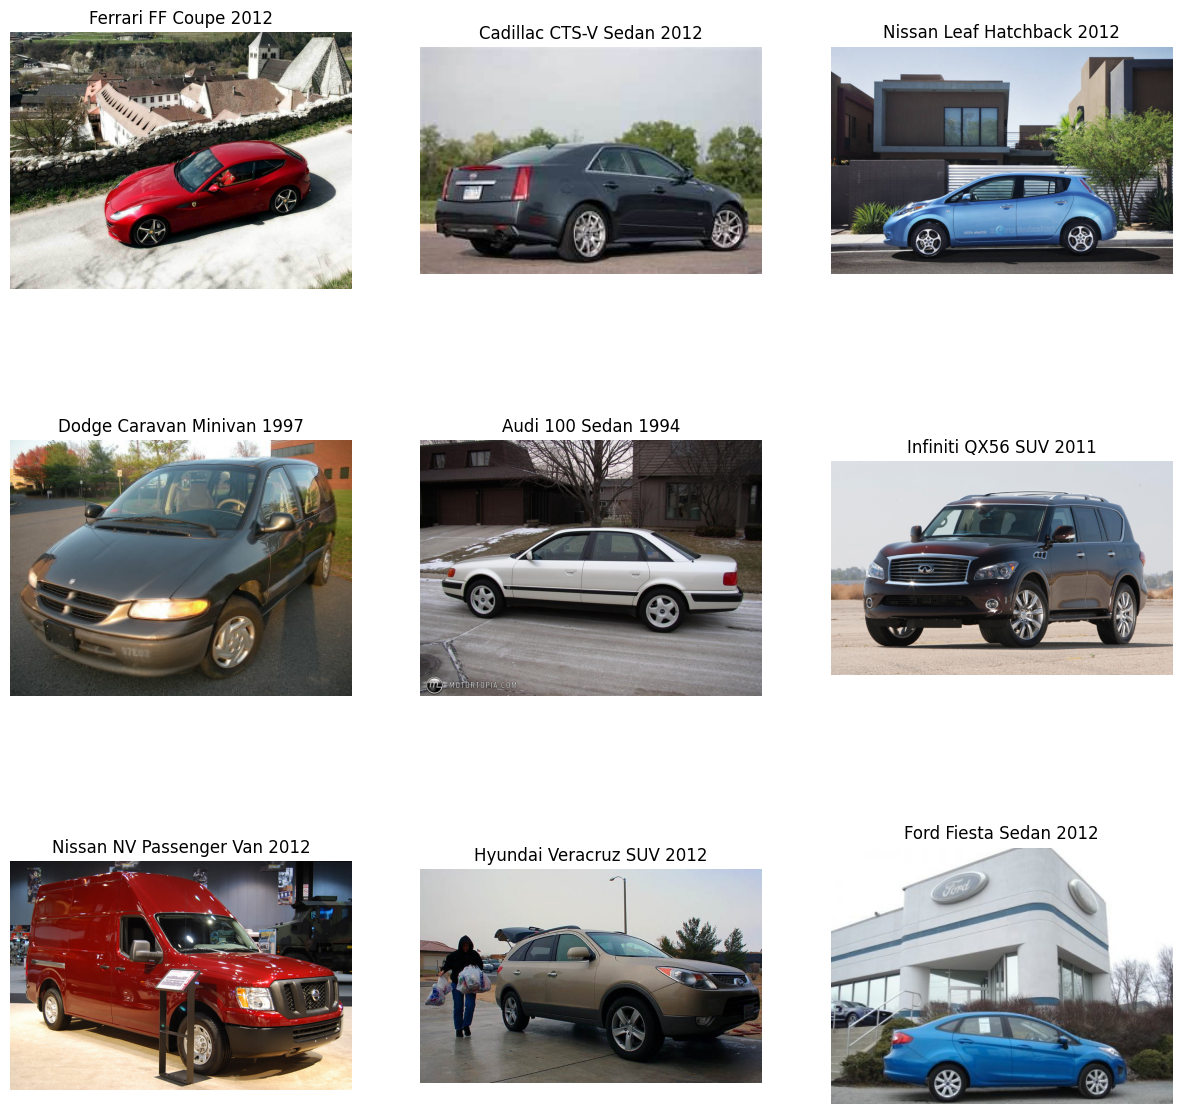

In [8]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(TRAIN_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

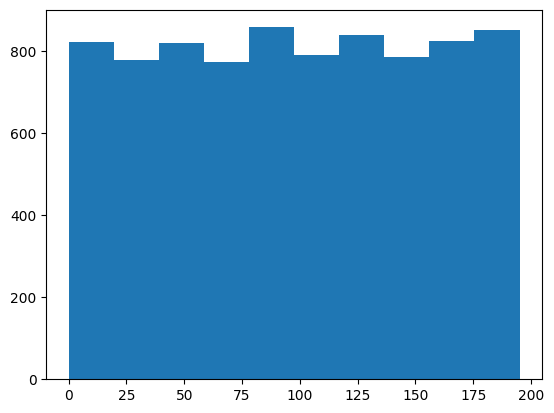

In [9]:
plt.hist(fname_to_class.values())
plt.show()

#### 2. Аугментации

Будем использовать следующие аугментации для обучения:
1. Resize - фиксированный размер ускоряет обучение и можно использовать batch_size > 1.
2. HorizontalFlip - горизонтальное отражение.
3. ShiftScaleRotate - сдвигает, масштабирует и поворачивает изображение.
4. RandomBrightnessContrast - изменяет яркость и контраст изображения.
5. HueSaturationValue - измененяет цвета изображения в пространстве HSV (оттенок-насыщенность-яркость), что позволяет изменять цвета мячей,
   а также имитировать разное освещение.
6. MotionBlur - делает размытие изображения, что имитирует размытие при движении камеры или объекта.
7. GaussNoise - Добавляет случайный шум к каждому пикселю изображения.

In [10]:
train_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=15,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.3
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.4
    ),
    A.HueSaturationValue(p=0.3),
    A.MotionBlur(blur_limit=7, p=0.15),
    A.GaussNoise(p=0.1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]

        image = cv2.imread(os.path.join(TRAIN_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']
        sample = {'image': image, 'label': cl_id}
        return sample

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [11]:
items = list(fname_to_class.items())
random.seed(42)
random.shuffle(items)

train_items = items[:int(len(items) * 0.7)]
val_items = items[int(len(items) * 0.7):int(len(items) * 0.85)]
test_items = items[int(len(items) * 0.85):]

train_dataset = CarsDataset(train_items, train_transforms)
val_dataset = CarsDataset(val_items, val_transforms)
test_dataset = CarsDataset(test_items, val_transforms)

#### Формирование триплетов

Так как в качестве лосса берётся Triplet loss, то для каждого выбраннного объекта из батча, должны быть объекты того же класса из этого батча, т.к. иначе не будет positive пар и не получится сфорировать триплет, а значит посчитать лосс. Поэтому, если взять произвольный батч, то нет гарантии, что будут объекты с повторяющимися классами. Для решения этой проблемы будем использовать CarBatchSampler, который гарантирует повторение классов в батче.

In [33]:
def CarBatchSampler(len_dataset, items, batch_size, labels_per_batch):
    labels = np.array([label for _, label in items], dtype=np.int64)

    m_sampler = MPerClassSampler(
        labels,
        m=labels_per_batch,
        length_before_new_iter=len_dataset
    )

    batch_sampler = BatchSampler(
        m_sampler,
        batch_size=batch_size,
        drop_last=True
    )
    return batch_sampler

In [34]:
batch_size = 32
labels_per_batch = 8

batch_sampler_train = CarBatchSampler(
    len(train_dataset),
    train_items,
    batch_size,
    labels_per_batch
)

batch_sampler_val = CarBatchSampler(
    len(val_dataset),
    val_items,
    batch_size,
    labels_per_batch
)

In [35]:
train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler_train, num_workers=1, pin_memory=True)
valid_loader = DataLoader(val_dataset, batch_sampler=batch_sampler_val, num_workers=1, collate_fn=None, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

Проверим, что батч содержит batch_size / labels_per_batch = 4 уникальных класса

In [36]:
batch = next(iter(train_loader))
print(f"Batch size: {len(batch['label'])}")
print(f"Labels: {batch['label']}")

unique = np.unique(batch['label'].numpy())
print(f"Unique classes: {len(unique)}")

Batch size: 32
Labels: tensor([143, 143, 143, 143, 143, 143, 143, 143,  29,  29,  29,  29,  29,  29,
         29,  29,  31,  31,  31,  31,  31,  31,  31,  31,  70,  70,  70,  70,
         70,  70,  70,  70], dtype=torch.uint8)
Unique classes: 4


Аугментации на train выборке

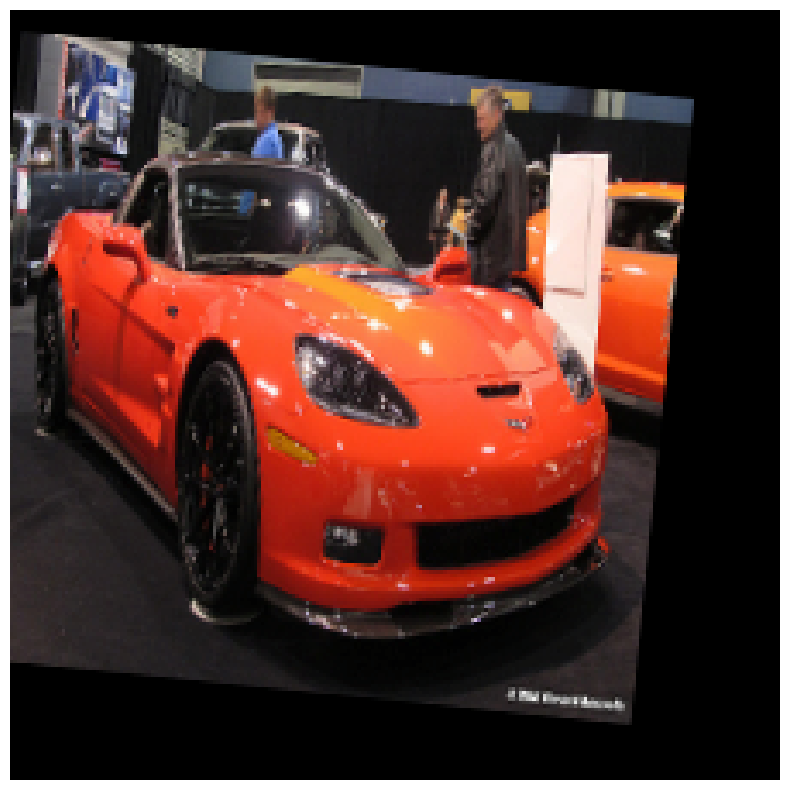

In [37]:
iterator = iter(train_dataset)
sample = next(iterator)
image = sample['image']
show_image(image)

Аугментации на val выборке - их нет)

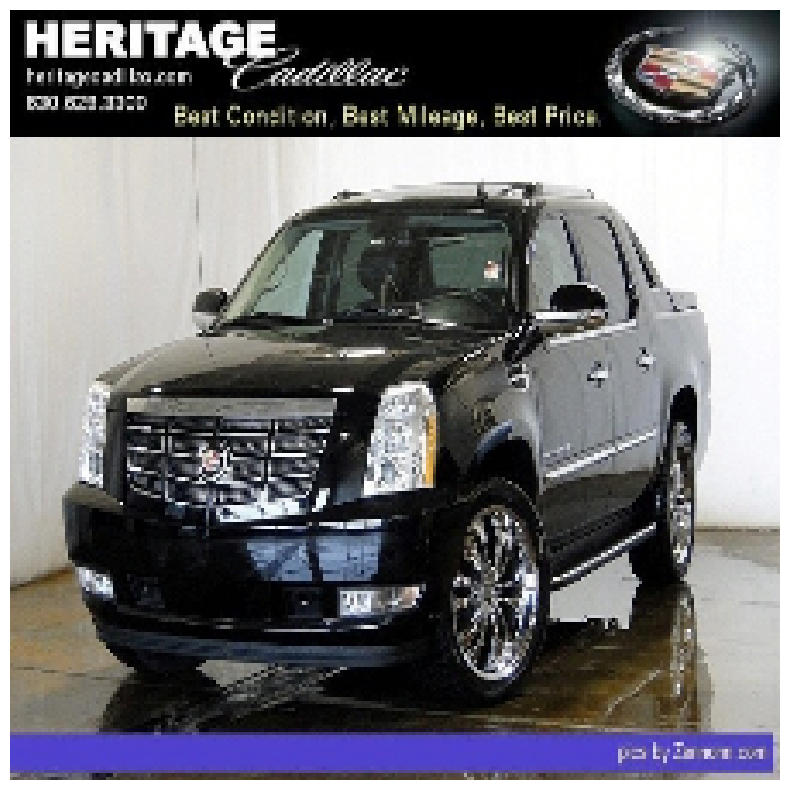

In [38]:
iterator = iter(val_dataset)
sample = next(iterator)
image = sample['image']
show_image(image)

### Обучение модели Metric Learning

В качестве лосса используется Triplet loss. Будем использовать разные miner-ы в зависимости от лосса на валидации. На ранних эпохах используем hard triplets, если val loss не улучшается, то переходим на semi-hard triplets. Пробовал ещё переходить на easy triplets, если val loss не улучшается для semi-hard, но почему-то после этого я получал val loss = 0 (скорее всего mining не находит триплетов на валидации). В качестве предобученной модели была выбрана DenseNet. На выходе модель выдаёт эмбеддинг.

In [39]:
class CarEmbedder(pl.LightningModule):
    def __init__(self, lr=3e-4, margin=0.2, emb_size=512, val_loss_iter_no_change=2):
        super().__init__()
        self.lr = lr
        self.emb_size = emb_size

        self.model = timm.create_model('densenet121', pretrained=True)
        self.model.classifier = nn.Linear(1024, emb_size)

        self.triplet_loss = losses.TripletMarginLoss(margin=margin)

        self.miners = {
            'hard': miners.BatchHardMiner(),
            'semi_hard': miners.TripletMarginMiner(margin=margin, type_of_triplets='semihard')
        }

        self.current_miner = 'hard'
        self.mining_patience = 0
        self.best_val_loss = float('inf')
        self.val_loss_iter_no_change = val_loss_iter_no_change

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)

        miner = self.miners[self.current_miner]
        mining_pairs = miner(embeddings, labels)

        loss = self.triplet_loss(embeddings, labels, mining_pairs)
        self.log("train_loss", loss, sync_dist=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']

        embeddings = self(images)

        miner = self.miners[self.current_miner]
        mining_pairs = miner(embeddings, labels)
        loss = self.triplet_loss(embeddings, labels, mining_pairs)

        self.log("val_loss", loss, sync_dist=True, prog_bar=True)
        return loss

    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images)
        else:
            preds = self.model(images.unsqueeze(0))
        return preds

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get('val_loss', None)

        if val_loss is None:
            return

        curr_val_loss = val_loss.item()

        if curr_val_loss < self.best_val_loss:
            self.best_val_loss = curr_val_loss
            self.mining_patience = 0
        else:
            self.mining_patience += 1

        if self.mining_patience >= self.val_loss_iter_no_change:
            if self.current_miner == 'hard':
                self.current_miner = 'semi_hard'
                self.mining_patience = 0

        print(f"miner in epoch {self.current_epoch}: {self.current_miner}")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss'}
        }

In [40]:
pl_model = CarEmbedder(lr=3e-4, margin=0.2, emb_size=256, val_loss_iter_no_change=2)
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=4)
lr_monitor = LearningRateMonitor(logging_interval='step')

In [41]:
trainer = pl.Trainer(
    max_epochs=30,
    accelerator=device,
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor]
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [42]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | model        | DenseNet          | 7.2 M  | train
1 | triplet_loss | TripletMarginLoss | 0      | train
-----------------------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.865    Total estimated model params size (MB)
562       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | model        | DenseNet          | 7.2 M  | train
1 | triplet_loss | TripletMarginLoss | 0      | train
-----------------------------------------------------------
7.2 M     Trainable params
0         Non-trainable params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

miner in epoch 0: hard


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 0: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 1: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 2: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 3: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 4: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 5: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 6: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 7: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 8: hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 9: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 10: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 11: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 12: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 13: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 14: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 15: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 16: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 17: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 18: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 19: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 20: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 21: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 22: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 23: semi_hard


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 24: semi_hard


### Инференс модели

Предсказывать класс объекта будем с помощью Faiss. CarEmbedderInference с помощью Faiss кластеризует эмбеддинги из train, делает эмбеддинг из объекта query с помощью нашей модели, находит k-ближайших эмбеддингов к query из train выборки с помощью Faiss, а затем с помощью голосования выбирает наиболее часто встречающийся класс у k-ближайших эмбеддингов.

In [43]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

miner in epoch 25: semi_hard


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.0923377275466919     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.0923377275466919}]

In [44]:
class CarEmbedderInference:
    def __init__(self, model, train_dataloader):
        self.model = model
        self.model.to(device)
        self.model.eval()

        self.train_dataloader = train_dataloader
        self.train_labels = None
        self.train_embeddings = None
        self.faiss_index = self.build_faiss_index()

    def extract_embeddings(self, dataloader):
        all_embeddings = []
        all_labels = []

        with torch.no_grad():
            for batch in dataloader:
                images = batch['image'].to(device)

                labels = batch['label']
                all_labels.append(labels.numpy())

                embeddings = self.model(images)
                all_embeddings.append(embeddings.cpu().numpy())

        embeddings = np.vstack(all_embeddings)
        labels = np.concatenate(all_labels)

        return embeddings, labels

    def build_faiss_index(self):
        train_embeddings, train_labels = self.extract_embeddings(self.train_dataloader)
        self.train_labels = train_labels
        self.train_embeddings = train_embeddings

        faiss_index = faiss.IndexFlatL2(self.model.emb_size)
        faiss_index.add(train_embeddings)
        return faiss_index

    def predict(self, test_loader, k=5):
        test_embeddings, test_labels = self.extract_embeddings(test_loader)

        distances, indices = self.faiss_index.search(test_embeddings, k)

        predictions = []
        for i in range(len(test_embeddings)):
            neighbors_labels = self.train_labels[indices[i]]
            pred_class = np.bincount(neighbors_labels.astype(int)).argmax()
            predictions.append(pred_class)

        predictions = np.array(predictions)

        return predictions, test_labels, indices, distances

In [45]:
inference_faiss = CarEmbedderInference(pl_model, train_loader)
predictions, test_labels, indices, distances = inference_faiss.predict(test_loader)

In [28]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4100


### 1. Оценка качества работы модели
Все метрики считаем усреднённо, то ест для всех объектов из тестовой выборки.

Для одного объекта метрики работают так:
- precision@k: находим k-ближайших эмбеддингов в query, берём их классы, среди них находим число релевантных эмбеддингов, т.е. таких эмбеддингов, у которых класс совпал с классом query. Это число делим на k. \
**Интуитивно**: насколько точно модель смогла найти k-похожих эмбеддингов для эмбеддинга query, где точность характеризуется равенством классов эмбеддинга query и k-ближайших.
- recall@k: аналогично precision@k находим число релевантных k-ближайших эмбеддингов к query и делим их на число всех релеватных эмбеддингов из train, т.е. всех эмбеддингов из train, класс которых совпадает с классом query. \
**Интуитивно**: какое число эмбеддингов из train, имеющих тот же класс, что и query, покрывается k-ближайшими эмбеддингами, которые выдаёт модель.
- AP (average precision - mAP просто усредняет для каждого query из test выборки): находим total_relevant = число всех релеватных эмбеддингов из train, далее находим precision@k для query, где 1 <= k <= total_relevant, суммируем и делим на total_relevant. \
**Интуитивно**: насколько точно модель ранжирует k-ближайших эмбеддингов по релевантности? то есть самые близкие эмбеддинги должны быть того же класса, что и query.

In [46]:
def precision_at_k(indices, test_labels, train_labels, k):
    precisions = []

    for i in range(len(test_labels)):
        retrieved_labels = train_labels[indices[i, :k]]
        query_label = test_labels[i]
        relevant = (retrieved_labels == query_label)
        precision = relevant.sum() / k
        precisions.append(precision)

    return np.mean(precisions)

def recall_at_k(indices, test_labels, train_labels, k):
    recalls = []

    for i in range(len(test_labels)):
        retrieved_labels = train_labels[indices[i, :k]]
        query_label = test_labels[i]

        relevant_found = (retrieved_labels == query_label).sum()
        total_relevant = (train_labels == query_label).sum()

        if total_relevant == 0:
            recall = 0.0
        else:
            recall = relevant_found / total_relevant

        recalls.append(recall)

    return np.mean(recalls)

def average_precision(retrieved_labels, query_label):
    relevant = (retrieved_labels == query_label)

    if relevant.sum() == 0:
        return 0.0

    precisions = []
    num_relevant = 0

    for i, is_relevant in enumerate(relevant):
        if is_relevant:
            num_relevant += 1
            precision_at_i = num_relevant / (i + 1)
            precisions.append(precision_at_i)

    return np.mean(precisions)

def mAP_score(indices, test_labels, train_labels):
    aps = []

    for i in range(len(test_labels)):
        retrieved_labels = train_labels[indices[i]]
        query_label = test_labels[i]

        ap = average_precision(retrieved_labels, query_label)
        aps.append(ap)

    return np.mean(aps)

In [30]:
prec_at_5 = precision_at_k(indices, test_labels, inference_faiss.train_labels, k=5)
rec_at_5 = recall_at_k(indices, test_labels, inference_faiss.train_labels, k=5)
mAP = mAP_score(indices, test_labels, inference_faiss.train_labels)
print(f"Precision@5: {prec_at_5}, Recall@5: {rec_at_5}, mAP: {mAP}")

Precision@5: 0.3351882160392799, Recall@5: 0.07052986906710311, mAP: 0.48680441898527005


### Оценка качества обучения модели с помощью GradCam

Покажем с помощью GradCam где ошибается модель. Для этого к эмбеддингу объекта из test выборки находим ближайший эмбеддинг из train выборки. Используем для этого индекс ближайшего эмбеддинга из train выборки, который мы знаем от Faiss. GradCam анализирует эти эмбеддинги и определяет, куда посмотрела модель на инференсе.

In [47]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features

    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

def show_gradcam_for_predictions(
    model,
    test_dataset,
    predictions,
    test_labels,
    indices,
    inference_faiss,
    id_to_car,
    num_images=3
):
    model.eval()

    target_layers = [model.model.features.denseblock4.denselayer16.conv2]

    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
    if num_images == 1:
        axes = [axes]

    for idx in range(num_images):
        sample = test_dataset[idx]
        image_tensor = sample['image'].unsqueeze(0).to(device)
        true_label = test_labels[idx]
        pred_label = predictions[idx]

        nearest_idx = int(indices[idx, 0])
        nearest_emb = torch.from_numpy(
            inference_faiss.train_embeddings[nearest_idx]
        ).to(device)

        targets = [SimilarityToConceptTarget(nearest_emb)]

        with GradCAM(model=model.model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0, :]

        img_denorm = inv_normalize(sample['image']).permute(1, 2, 0).numpy()

        cam_image = show_cam_on_image(img_denorm, grayscale_cam, use_rgb=True)

        axes[idx].imshow(cam_image)
        axes[idx].set_title(
            f"True: {id_to_car[true_label]}\n"
            f"Predict: {id_to_car[pred_label]}"
        )
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

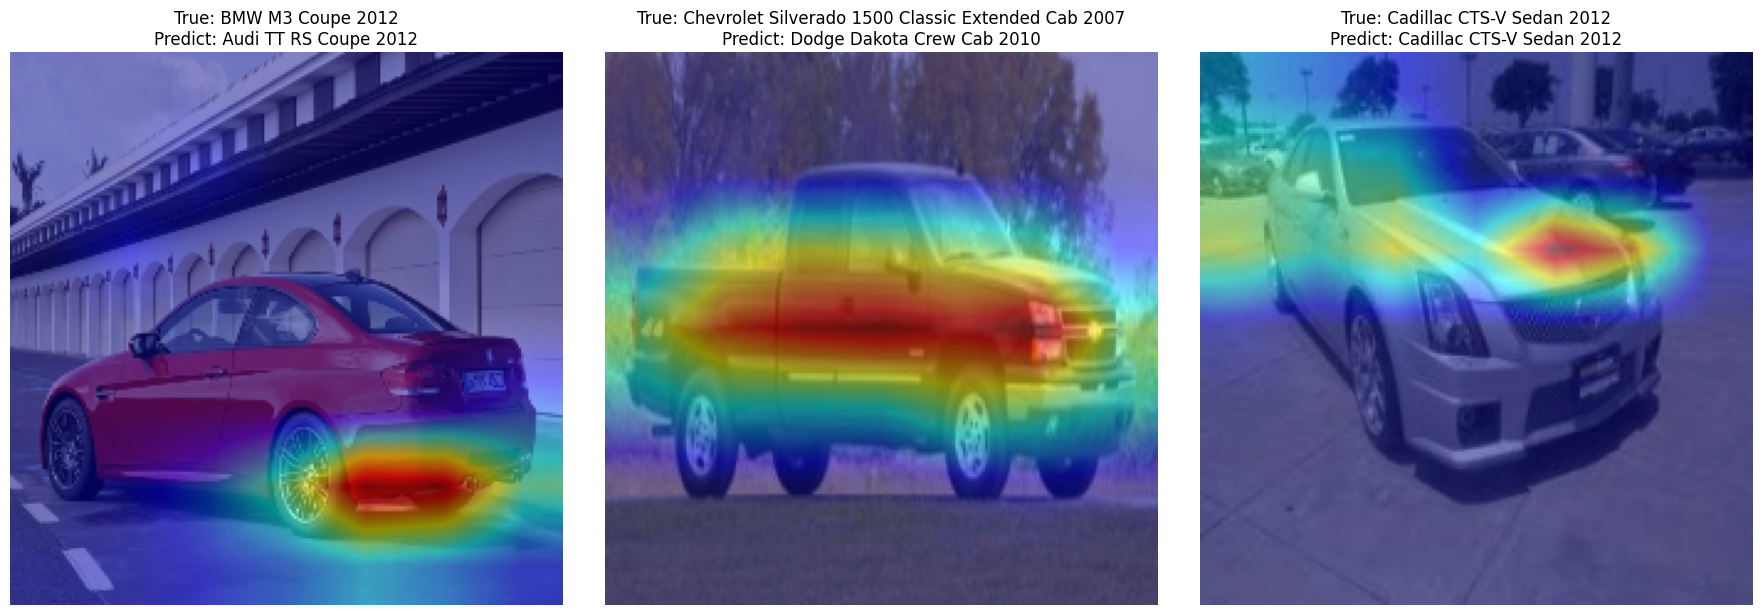

In [48]:
show_gradcam_for_predictions(
    model=pl_model,
    test_dataset=test_dataset,
    predictions=predictions,
    test_labels=test_labels,
    indices=indices,
    inference_faiss=inference_faiss,
    id_to_car=id_to_car,
    num_images=3
)

### Вывод по GradCam

На 1-ом фото модель смотрит на нижнюю часть автомобиля, но при этом игнорирует заднюю и верхнюю части, которые лучше характеризуют бмв. На 2-ом фото модель смотрит на всю машину целиком и определяет тип машины – пикап. Но модель не смотрит на марку машины, отсюда и предсказывает очень похожую машину (тоже пикап), но другой марки. На 3-ем фото модель правильно предсказывает класс – больше всего модель смотрит на капот машины, который скорее всего характерен для этого кадиллака.

### Общий вывод

В целом, модель даёт не очень хорошее качество, все эпохи она не обучается - срабатывает EarlyStopping коллбек. Возможно это связано с использованием Triplet loss, кажется что ArcFace и CenterLoss лучше бы себя показали. Либо же с формированием  mining-ов из батчей – после переключения на semi-hard модель постепенно перестаёт обучаться. Хотя в целом эта задача довольно сложная, т.к. датасет включает много классов и изображения машин разного качества.